In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import json
import math
%matplotlib inline
import warnings
from matplotlib.ticker import FormatStrFormatter
warnings.filterwarnings('ignore')
from matplotlib import gridspec

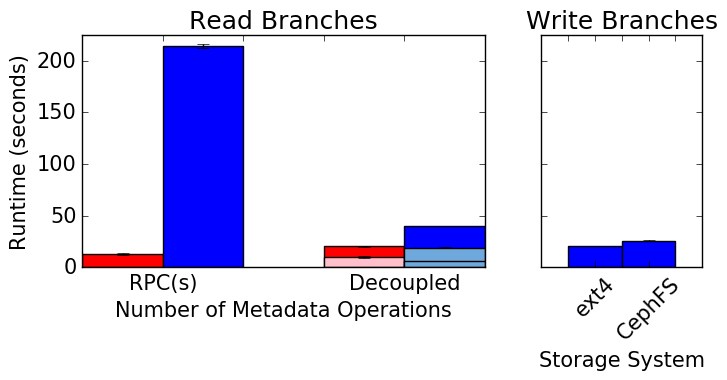

In [81]:
def to_seconds(timestamp):
    ts = timestamp.split(':')
    try: return float(float(ts[0])*60*60 + float(ts[1])*60 + float(ts[2]))
    except: return float(0)
    
def parse(expdir):
    df = pd.DataFrame(columns=['job', 'rtime', 'ts'])
    for run in [0, 1, 2, 3, 4, 5]:
        rundir = expdir + '-run' + str(run)
        with open(rundir + '/summary.txt') as f:
            d = pd.read_csv(f, names=['job', 'delta', 'time'])
            d['rtime'] = d['delta'].apply(to_seconds)
            del d['time'], d['delta']
            d['run'] = run
            df = df.append(d, ignore_index=True)
    return df.pivot(index='run', values='rtime', columns='job')

font = {'size'   : 15}; matplotlib.rc('font', **font)
args = {'width': 1, 'capsize': 4, 'ecolor': 'black'}
#fig, ax = plt.subplots(1, 1, figsize=(14, 3))
fig = plt.figure(figsize=(8,3))
gs = plt.GridSpec(1, 2, width_ratios=[5, 2]) 


df = parse('../results')
ax = plt.subplot(gs[0])
ax.bar([0], df['read_cephfs'].mean(), yerr=df['read_cephfs'].std(), color='red', **args)
ax.bar([1], df['read_fpb_cephfs'].mean(), yerr=df['read_fpb_cephfs'].std(), color='blue', **args)
ax.bar([3], df['get'].mean() + df['read_hep_ext4'].mean(), yerr=df['read_hep_ext4'].std(), color='red', **args)
ax.bar([3], df['get'].mean(), yerr=df['get'].std(), color='pink', **args)

stacked = [df['get'].mean()*0.65, df['read_fpb_ext4'].mean(), df['write_fpb_ext4'].mean()]
ax.bar([4], stacked[0] + stacked[1] + stacked[2], yerr=df['read_fpb_ext4'].std(), color='blue', label='Namespace', **args)
ax.bar([4], stacked[0] + stacked[1], yerr=df['write_fpb_ext4'].std(), color="#6fa8dc", label='Namespace', **args)
ax.bar([4], stacked[0], yerr=df['write_fpb_ext4'].std(), color="#6fa8dc", label='Namespace', **args)
ax.set_xticklabels(["", "RPC(s)","","","Decoupled",""])#, rotation=20)
#ax.set_ylim(10**0, 10**3)
#ax.set_yscale('log')
ax.set_ylim(0, 225)

ax.set_ylabel("Runtime (seconds)")
ax.set_xlabel("Number of Metadata Operations")
ax.set_title("Read Branches")
#ax.legend(loc='upper left')
ax.legend().remove()

ax = plt.subplot(gs[1])
ax.bar([0.5], df['write_fpb_ext4'].mean(), yerr=df['write_fpb_ext4'].std(), color='blue', **args)
ax.bar([1.5], df['write_fpb_cephfs'].mean(), yerr=df['write_fpb_cephfs'].std(), color='blue', **args)
ax.set_ylim(0, 225)
ax.set_xlim(0, 3)
ax.set_yticklabels([])
#ax.set_yscale('log')
ax.set_xticklabels(["", "", "ext4", "", "CephFS"], rotation=45)
ax.set_title("Write Branches")
ax.set_xlabel("Storage System")

#plt.savefig('../../../paper/figures/hep_runtime.png', dpi=300, bbox_inches='tight')
#df.mean()


In [45]:
print "write bandwidth = " + str((1745997813/df['put'].mean())/(1024*1024))
print "read  bandwidth = " + str((1745997813/df['get'].mean())/(1024*1024))

write bandwidth = 122.536545198
read  bandwidth = 166.141907775


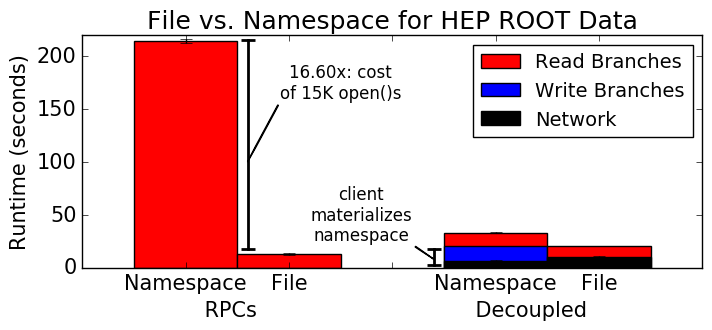

In [222]:
font = {'size'   : 15}; matplotlib.rc('font', **font)
args = {'width': 1, 'capsize': 4, 'ecolor': 'black'}
fig, ax = plt.subplots(1, 1, figsize=(8, 3))

df = parse('../results')
ax.bar([0.5], df['read_fpb_cephfs'].mean(), yerr=df['read_fpb_cephfs'].std(), color='red', **args)
ax.bar([1.5], df['read_cephfs'].mean(), yerr=df['read_cephfs'].std(), color='red', label='Read Branches', **args)

#stacked
s = [df['get'].mean()*0.65, df['write_fpb_ext4'].mean()*0.65, df['read_fpb_ext4'].mean()]
ax.bar([3.5], s[0]+s[1]+s[2], yerr=df['read_fpb_ext4'].std(),  color='red', **args)
ax.bar([3.5], s[0]+s[1],      yerr=df['write_fpb_ext4'].std(), color="blue", label="Write Branches", **args)
ax.bar([3.5], s[0],           yerr=df['get'].std(),            color="black", **args)

ax.bar([4.5], df['get'].mean() + df['read_hep_ext4'].mean(), yerr=df['read_hep_ext4'].std(), color='red', **args)
ax.bar([4.5], df['get'].mean(), yerr=df['get'].std(), color='black', label="Network", **args)

ax.set_xticklabels(["", "Namespace", "File","","Namespace","File",""])#, rotation=20)
ax.set_xlabel(" RPCs                                 Decoupled")
ax.set_ylabel("Runtime (seconds)")
ax.set_title("File vs. Namespace for HEP ROOT Data")
#ax.set_ylim(10**0, 10**3)
#ax.set_yscale('log')

ax.set_ylim(0, 220)
ax.legend(fontsize=14)
arrw = dict(facecolor='black', headwidth=0.5, width=0.5, shrink=1)
args = {'horizontalalignment': 'center', 'verticalalignment': 'center', 'fontsize': 12, 'arrowprops': arrw}
#ax.axvline(x=1)
ax.axvline(x=1.6, ymin=0.08, ymax=0.98, lw=2, c='black', marker='_', ms=10, mew=2)
ax.annotate("16.60x: cost\nof 15K open()s", xy=(1.6, 100), xytext=(2.5, 175), **args)

ax.axvline(x=3.4, ymin=0.01, ymax=0.08, lw=2, c='black', marker='_', ms=10, mew=2)
ax.annotate("client\nmaterializes\nnamespace", xy=(3.4, 8), xytext=(2.7, 50), **args)

plt.savefig('../../../paper/figures/hep_runtime.png', dpi=300, bbox_inches='tight')

In [177]:
df.mean()

job
get                  10.022235
put                  13.588707
read_cephfs          12.902586
read_fpb_cephfs     214.130339
read_fpb_ext4        12.742729
read_hep_ext4        10.491887
write_cephfs          3.400378
write_fpb_cephfs     25.878283
write_fpb_ext4       21.040522
dtype: float64